# 1. Introduction

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, randint
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm, metrics
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load data
heart_data = pd.read_csv('processed.cleveland.data',header=None)
heart_data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

In [3]:
# Take a preliminary look at the data
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [4]:
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


At first glance, it appears that the data looks clean. However, the data repository states that the 'ca' and 'thal' columns have missing values so we'll take a closer look at these columns.

In [5]:
heart_data['ca'].value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64

In [6]:
heart_data['thal'].value_counts()

3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64

It appears that there are some '?' values in these two columns. There are a few ways we can deal with this. One possible way would be to drop the rows with the '?' values. Another possible way would be to replace the '?' values with the mean, median, or mode of the column. To preserve the data, I will replace the '?' values with the mode of the column.

# 2. Cleaning the data

In [7]:
heart_data['ca'].replace('?',str(0.0),inplace=True)

In [8]:
heart_data['ca'].value_counts()

0.0    180
1.0     65
2.0     38
3.0     20
Name: ca, dtype: int64

In [9]:
heart_data['thal'].replace('?',str(3.0),inplace=True)

In [10]:
heart_data['thal'].value_counts()

3.0    168
7.0    117
6.0     18
Name: thal, dtype: int64

The '?' values have been replaced with the mode of the column. Now we can check the data types of each column to make sure they are in the right format.

In [11]:
heart_data.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
num           int64
dtype: object

We can convert the 'ca' and 'thal' columns from object to float to be able to do mathamatical calculations on them.

In [12]:
heart_data['ca'] = heart_data['ca'].astype(float)
heart_data['thal'] = heart_data['thal'].astype(float)

We can check again to make sure the data types are correct.

In [13]:
heart_data.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num           int64
dtype: object

# 3. Exploratory Data Analysis

We will modify the heart_data dataframe in a new dataframe to perform EDA.

In [14]:
heart_copy = heart_data.copy()

In [15]:
heart_copy['sex'] = heart_copy['sex'].replace([1.0,0.0],['Male','Female'])
heart_copy['cp'] = heart_copy['cp'].replace([1.0,2.0,3.0,4.0],['Typical Angina','Atypical Angina','Non-anginal Pain','Asymptomatic'])
heart_copy.rename(columns={'num':'heart_disease'},inplace=True)
heart_copy['heart_disease'] = heart_copy['heart_disease'].replace([0,1,2,3,4],['Absence','Presence','Presence','Presence','Presence'])

Now that the data is ready for EDA, the first question we will ask is if there is an association between thalach and whether a person will be diagnosed with heart disease.

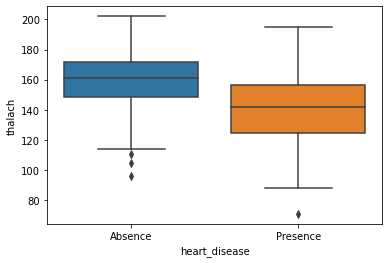

In [16]:
sns.boxplot(x='heart_disease',y='thalach',data=heart_copy)
plt.show()

From the boxplot, it appears that thalach (the maximum heartrate achieved during the test) may be associated with whether a person may be diagnosed with heart disease. We will investigate this further.

In [17]:
thalach_hd = heart_copy[heart_copy.heart_disease == 'Presence']['thalach']
thalach_no_hd = heart_copy[heart_copy.heart_disease == 'Absence']['thalach']

In [18]:
'Mean difference: ' + str(np.mean(thalach_hd) - np.mean(thalach_no_hd))

'Mean difference: -19.11905597473242'

In [19]:
'Median difference: ' + str(np.median(thalach_hd) - np.median(thalach_no_hd))

'Median difference: -19.0'

It appears that there may be a significant difference between the average thalach for people with heart disease and people without heart disease. We will conduct a two-sample t-test to confirm if there is a difference.

In [20]:
t_stat,pval = ttest_ind(thalach_hd,thalach_no_hd)
pval

3.456964908430172e-14

Since this p-value is much smaller than the threshold of 0.05, we can reject the null hypothesis and conclude that there is a significant difference in average thalach for people with heart disease compared with people with no heart disease. We will perform the same process now for the chol variable.

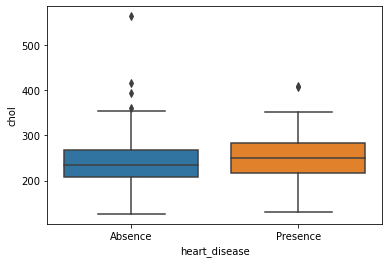

In [21]:
sns.boxplot(x='heart_disease',y='chol',data=heart_copy)
plt.show()

In [22]:
chol_hd = heart_copy[heart_copy.heart_disease == 'Presence']['chol']
chol_no_hd = heart_copy[heart_copy.heart_disease == 'Absence']['chol']

In [23]:
'Mean difference: ' + str(np.mean(chol_hd) - np.mean(chol_no_hd))

'Mean difference: 8.834576241445887'

In [24]:
'Median difference: ' + str(np.median(chol_hd) - np.median(chol_no_hd))

'Median difference: 14.5'

In [25]:
t_stat2,pval2 = ttest_ind(chol_hd,chol_no_hd)
pval2

0.13914167020436527

This p-value we obtained is greater than the threshold value of 0.05. Thus, we can conclude that there is no significant difference in cholesterol levels for people with heart disease compared with people with no heart disease.

Next, we will investigate the relationship between thalach and the type of chest pain (cp) a patient experiences.

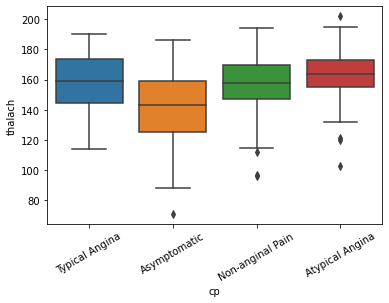

In [26]:
sns.boxplot(x='cp',y='thalach',data=heart_copy)
plt.xticks(rotation=30)
plt.show()

It appears that there may be differences in thalach between the different types of chest pains a patient experiences. We will investigate this further.

In [27]:
thalach_typical = heart_copy[heart_copy['cp'] == 'Typical Angina']['thalach']
thalach_asymptom = heart_copy[heart_copy['cp'] == 'Asymptomatic']['thalach']
thalach_nonangin = heart_copy[heart_copy['cp'] == 'Non-anginal Pain']['thalach']
thalach_atypical = heart_copy[heart_copy['cp'] == 'Atypical Angina']['thalach']

In [28]:
f_stat,pval3 = f_oneway(thalach_typical,thalach_asymptom,thalach_nonangin,thalach_atypical)
pval3

1.9065505247705008e-10

We ran AVONA and got a p-value less than 0.05. Thus, we can conclude that there is at least one group of chest pain categories for which people have significantly different thalach values. To find out which pairs are significantly different, we will conduct a post-hoc test such as a pairwise Tukey's HSD test.

In [29]:
results = pairwise_tukeyhsd(endog = heart_copy.thalach,groups=heart_copy.cp)
print(results)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------
    Asymptomatic  Atypical Angina  21.7394  0.001  12.7439  30.735   True
    Asymptomatic Non-anginal Pain  14.7264  0.001    7.258 22.1948   True
    Asymptomatic   Typical Angina   15.276 0.0081   2.9702 27.5817   True
 Atypical Angina Non-anginal Pain   -7.013 0.2481 -16.7591   2.733  False
 Atypical Angina   Typical Angina  -6.4635 0.6069 -20.2707  7.3438  False
Non-anginal Pain   Typical Angina   0.5495    0.9  -12.315 13.4141  False
-------------------------------------------------------------------------


It appears that there is a significant difference in thalach levels for people with Asymptomatic and Atypical Angina, Asymptomatic and Non-anginal Pain, and Asymptomatic and Typical Angina. These results make sense given the box plot.

The last question we will ask before we move onto machine learning is if there is an association between the type of chest pain a patient experiences and whether they have heart disease or not.

In [30]:
Xtab = pd.crosstab(heart_copy.cp,heart_copy.heart_disease)
Xtab

heart_disease,Absence,Presence
cp,,
Asymptomatic,39,105
Atypical Angina,41,9
Non-anginal Pain,68,18
Typical Angina,16,7


We have the contingency table. Now, we will conduct a chi-squared test to determine if there is an association between chest pain type and whether a person has heart disease or not.

In [31]:
t_stat2,pval4,df,freq = chi2_contingency(Xtab)
pval4

1.2517106007837527e-17

This p-value is much smaller than the threshold of 0.05. Thus, we can reject the null hypothesis and conclude that there is an association between chest pain type and whether a person has heart disease or not.

# 4. Machine Learning

To perform machine learning techniques to predict whether a person has heart disease or not, we will return to the original heart_data data set. We will have to modify the last column to have only 0s and 1s where 0 is no heart disease and 1 means the presence of heart disease.

In [32]:
heart_data['num'] = heart_data['num'].replace([2,3,4],[1,1,1])

Now we can start splitting the data into X and y.

In [33]:
X = heart_data.drop(columns='num')
y = heart_data['num'].values

Let's normalize X_train and X_test before performing KNN.

In [34]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [36]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

Now that we split the data and made a KNN classifier, we can use it to predict on the X_test data set and see how accurate this model is.

In [37]:
knn.predict(X_test)[0:5]

array([0, 1, 0, 0, 1], dtype=int64)

In [38]:
knn.score(X_test,y_test)

0.8524590163934426

We get an accuracy of 85.2% which is good. Let's see if we can make a better model with k-fold cross validation.

In [39]:
knn_cv = KNeighborsClassifier(n_neighbors = 3)
cv_scores = cross_val_score(knn_cv,X,y,cv=5)
cv_scores

array([0.81967213, 0.8852459 , 0.81967213, 0.86666667, 0.78333333])

In [40]:
np.mean(cv_scores)

0.8349180327868853

We get an average accuracy of 83.5% which is less than what we got before. Let's do some hyperparameter tuning to see if that will improve accuracy.

In [41]:
knn_2 = KNeighborsClassifier()
param_grid = {'n_neighbors':np.arange(1,30)}
knn_gridsearch = GridSearchCV(knn_2,param_grid,cv=5)
knn_gridsearch.fit(X,y)
knn_gridsearch.best_params_

{'n_neighbors': 5}

We see that the optimal number of neighbors is 5. Let's see what the score is when n_neighbors=5.

In [42]:
knn_gridsearch.best_score_

0.8380874316939891

The accuracy has increased slightly from when we performed cross validation. This accuracy is still slightly low, so we can try another machine learning algorithm like Support Vector Machine (SVM).

In [43]:
svm_class = svm.SVC(kernel='linear')
svm_class.fit(X_train,y_train)
y_pred = svm_class.predict(X_test)

In [44]:
metrics.accuracy_score(y_test,y_pred)

0.8524590163934426

The accuracy is similar to that of KNN. Let's look at the confusion matrix.

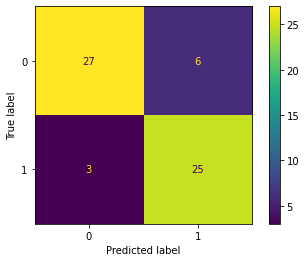

In [45]:
cm = metrics.confusion_matrix(y_test,y_pred)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

The linear SVC performs reasonably well. Let's take a look at how a polynomial SVC performs.

In [46]:
svm_class_poly = svm.SVC(kernel='poly')
svm_class_poly.fit(X_train,y_train)
y_pred_poly = svm_class_poly.predict(X_test)

In [47]:
metrics.accuracy_score(y_test,y_pred_poly)

0.8688524590163934

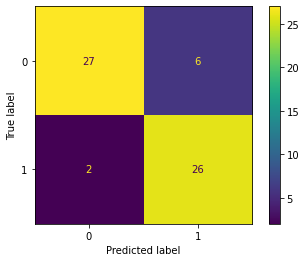

In [48]:
cm2 = metrics.confusion_matrix(y_test,y_pred_poly)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm2).plot()
plt.show()

The polynomial kernel performs slightly better than the linear kernel. The last machine learning algorithm we will try is a random forest.

In [49]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
metrics.accuracy_score(y_test,y_pred_rf)

0.9016393442622951

The accuracy is about the same as for the SVC. Let'd do some hyperparameter tuning to see if we can increase the accuracy.

In [50]:
param_dict = {'n_estimators':randint(50,500),'max_depth':randint(1,20)}
rf2 = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf2,param_distributions = param_dict,n_iter=5,cv=5)

In [51]:
rand_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DD582DB6D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DD585B34F0>})

In [52]:
rand_search.best_params_

{'max_depth': 19, 'n_estimators': 127}

In [53]:
rand_search.best_score_

0.8263605442176871

We have successfully performed a Random Forest Classification alonside KNN and SVM to predict whether a person has heart disease based on several factors.

# 5. Conclusion

In conclusion, in this project we explored a heart disease data set that includes several variables for 303 patients. We cleaned the data and performed exploratory data analysis where we learned much about the relationship between several variables and whether a person has heart disease. After that, we performed machine learning algorithms including KNN, SVM, and Random Forest to predict whether a person has heart disease based on several factors. Overall, we learned much from this dataset and I believe that it was a fun and exciting project to carry out.